<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/load_GCC_gt_as_csv_and_and_train_the_model_with_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [23]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 25.1 GB  | Proc size: 4.0 GB
GPU RAM Free: 1351MB | Used: 14929MB | Util  92% | Total 16280MB


In [24]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [26]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):

        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [27]:
import os
import random
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    #path = "/content/drive/MyDrive/GCC_CSV_DataSet/Part 0/scene_00_0/csv_den_maps_k15_s4_544_960"
    gt_path = img_path.replace('.png','.csv').replace('pngs_544_960','csv_den_maps_k15_s4_544_960')
    img = Image.open(img_path)
    target = pd.read_csv(gt_path, sep=',', header=None).values
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [28]:
model = TestNet()
model = model.cuda()

In [29]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC_CSV_DataSet/"+"Part"+"_"+scene[7]+scene+"/"+"pngs_544_960/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("data size: ",len(train_list))
  return train_list



In [30]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part0_train_list = extract_image_path_list(train_list, "Part_0")
part1_train_list = extract_image_path_list(train_list, "Part_1")
part2_train_list = extract_image_path_list(train_list, "Part_2")
part3_train_list = extract_image_path_list(train_list, "Part_3")
part4_train_list = extract_image_path_list(train_list, "Part_4")
part5_train_list = extract_image_path_list(train_list, "Part_5")
part6_train_list = extract_image_path_list(train_list, "Part_6")
part7_train_list = extract_image_path_list(train_list, "Part_7")
part8_train_list = extract_image_path_list(train_list, "Part_8")
part9_train_list = extract_image_path_list(train_list, "Part_9")

data size:  1320
data size:  1160
data size:  1258
data size:  1135
data size:  1055
data size:  1037
data size:  1000
data size:  1026
data size:  992
data size:  1461


In [31]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part0_test_list = extract_image_path_list(test_list, "Part_0")
part1_test_list = extract_image_path_list(test_list, "Part_1")
part2_test_list = extract_image_path_list(test_list, "Part_2")
part3_test_list = extract_image_path_list(test_list, "Part_3")
part4_test_list = extract_image_path_list(test_list, "Part_4")
part5_test_list = extract_image_path_list(test_list, "Part_5")
part6_test_list = extract_image_path_list(test_list, "Part_6")
part7_test_list = extract_image_path_list(test_list, "Part_7")
part8_test_list = extract_image_path_list(test_list, "Part_8")
part9_test_list = extract_image_path_list(test_list, "Part_9")

data size:  473
data size:  385
data size:  415
data size:  368
data size:  356
data size:  335
data size:  341
data size:  322
data size:  335
data size:  438


In [32]:
train_data = part0_train_list + part1_train_list+part2_train_list+part3_train_list+part4_train_list+part5_train_list+part6_train_list+part7_train_list+part8_train_list+part9_train_list
test_data = part0_test_list + part1_test_list+part2_test_list+part3_test_list+part4_test_list+part5_test_list+part6_test_list+part7_test_list+part8_test_list+part9_test_list

In [33]:
sou_main_transform = Compose([
        RandomCrop((480,480)),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])
train_loader = torch.utils.data.DataLoader(ListDataset(train_data,shuffle=True,
                                                                main_transform = sou_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [34]:
test_loader = torch.utils.data.DataLoader(ListDataset(test_data,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [35]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

In [37]:

def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [39]:
PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNet_checkpoint_gcc_data_Whole_aug.pth'
end_epoch = 15
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")
print(end_epoch , start_epoch)

Successfully load the check point
15 13


In [40]:
train_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/train_mae_part1and0.txt","a")
test_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/test_mae_part1and0.txt","a")
train_mae_file.truncate(0)
test_mae_file.truncate(0)

0

In [41]:
for epoch in range(start_epoch,end_epoch):
    losses = AverageMeter()
    model.train()
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img) 
        output = model(img)

        loss = criterion(output.squeeze(), target.squeeze().cuda())
        losses.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sou_pred_cnt, sou_label_cnt = mae_mse_update(output, target, train_mae, train_mse)
        if i % 1000 == 0:
            print('Epoch {}, Loss={:.4f} s_gt={:.1f} s_pre={:.1f}, lr={:.4f}'.format(
                    epoch, loss.item(), sou_label_cnt,sou_pred_cnt, optimizer.param_groups[0]['lr']*10000))
    
    #scheduler.step()  
    print('train_mae_sou', float(train_mae.avg), epoch)
    print('train_mse_sou', float(np.sqrt(train_mse.avg)), epoch)
    train_mae_file.write(str(train_mae.avg))
    train_mae_file.write("\n")
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH) 
    print("testing...................")  
    with torch.no_grad():
      model.eval()
      test_mae = AverageMeter()
      test_mse = AverageMeter()
      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output_test = model(img_test)

          sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae, test_mse)
          if j % 1000 == 0:
            print('Epoch {}, s_gt={:.1f} s_pre={:.1f} '.format(epoch, sou_label_cnt_test,sou_pred_cnt_test))
      print('test_mae_sou', float(test_mae.avg), epoch)
      print('test_mse_sou', float(np.sqrt(test_mse.avg)), epoch)
      test_mae_file.write(str(test_mae.avg))
      test_mae_file.write("\n")

train_mae_file.close()
test_mae_file.close()
MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withbackend.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch 13, Loss=3392.4014 s_gt=23.0 s_pre=15.1, lr=0.1000
Epoch 13, Loss=1381.0873 s_gt=42.3 s_pre=36.5, lr=0.1000
Epoch 13, Loss=49351.5312 s_gt=1316.8 s_pre=1387.1, lr=0.1000
Epoch 13, Loss=9298.5752 s_gt=166.3 s_pre=149.6, lr=0.1000
Epoch 13, Loss=420.7001 s_gt=0.0 s_pre=13.2, lr=0.1000
Epoch 13, Loss=2338.4546 s_gt=30.0 s_pre=48.9, lr=0.1000
train_mae_sou 34.71612787986424 13
train_mse_sou 66.93395318396072 13
testing...................
Epoch 13, s_gt=1895.6 s_pre=1936.8 
Epoch 13, s_gt=565.7 s_pre=361.1 
test_mae_sou 106.37844497231161 13
test_mse_sou 158.6500394138314 13
Epoch 14, Loss=3442.8232 s_gt=24.4 s_pre=-8.6, lr=0.1000
Epoch 14, Loss=6007.3164 s_gt=158.4 s_pre=124.3, lr=0.1000
Epoch 14, Loss=19089.0020 s_gt=515.9 s_pre=642.8, lr=0.1000
Epoch 14, Loss=7697.4189 s_gt=66.5 s_pre=27.9, lr=0.1000
Epoch 14, Loss=452.5775 s_gt=1.0 s_pre=2.5, lr=0.1000
Epoch 14, Loss=7270.6738 s_gt=27.1 s_pre=42.5, lr=0.1000
train_mae_sou 32.136807044283756 14
train_mse_sou 64.30248668547013 14
te

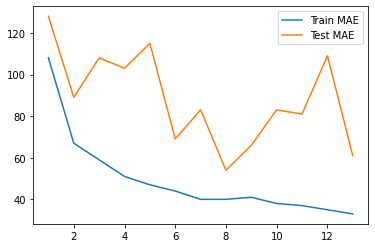

In [ ]:
import matplotlib.pyplot as plt


x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
y1 = [108 ,67]+[59, 51, 47]+[44, 40, 40 , 41,38,37 , 35,33,34,32]
y2 = [128,89]+[108, 103, 115]+[69, 83, 54,66 , 83,81,109,61,106,54]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])